In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import string

import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils
import linear_model

In [1]:
pd.__version__

NameError: name 'pd' is not defined

In [5]:
sns.__version__

'0.8.0'

In [6]:
gaba_fn = 'gaba_data.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [7]:
sdf = utils.load_psychophys(supp_fn)
gdf = utils.load_gaba(gaba_fn)

In [8]:
# Set the Population to be a categorical variable and change the names

In [9]:
#sdf.Population = sdf.Population.astype('category')
#sdf.Population.cat.categories # 0 AMB 1 CON
#sdf.Population = sdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted individuals'])

In [10]:
gdf.Population = gdf.Population.astype('category')
gdf.Population.cat.categories # 0 AMB 1 CON
gdf.Population = gdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted individuals'])

In [11]:
plot_dir = "plots/redo-201901"

## Analyze tasks separately (before subsetting to include common subjects)##

In [12]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em' 'es'
 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv' 'nl' 'nn'
 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm'
 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn' 'sd' 'tt'
 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [13]:
pop_group = gdf.groupby("Population")
pop_group.describe(percentiles=[.5])

GABA                                          
                             count      mean       std    min     50%    max
Population                                                                  
Persons with Amblyopia        16.0  0.202312  0.013385  0.179  0.2025  0.227
Normally-sighted individuals  15.0  0.206333  0.016482  0.173  0.2110  0.228

In [14]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group)
print(tstat, pval)

-0.747810754413 0.460595837907


** Thus we find no significant difference in GABA levels between CON and AMB. **

### GABA violin plot, all subjects

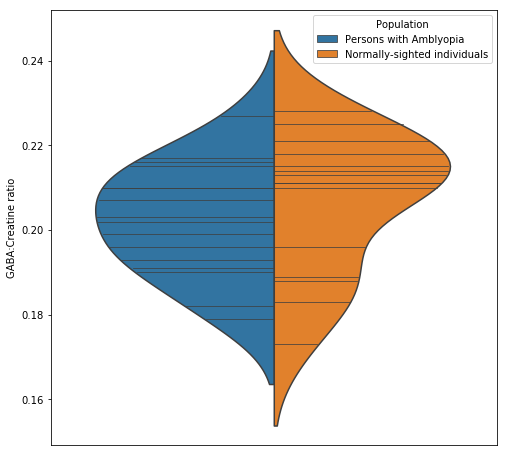

In [15]:
with s.PdfPages(f"{plot_dir}/gaba_diffs_n{n_gaba_subjs}.pdf") as pdf:
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gdf,split=True,inner='stick',ax=ax,legend=False)
    #ax.legend_.remove()
    ax.xaxis.set_visible(False)
    ax.set_ylabel('GABA:Creatine ratio')
    #ax.set_yticklabels([])
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

# Select one psychophysical task's data #

In [16]:
task = 'SS'
sdf = sdf[sdf['Task']==task]

In [17]:
df_to_model = sdf.copy() # make a deep copy

In [18]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="Amblyope"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


# Modeling

In [19]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [20]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

In [21]:
groups_with_baseline = df_to_model.groupby(pp_gvars_base)

In [22]:
#for gv, gr in groups_with_baseline:
#    print(gr)

### Linear model (defined in linear_model.py, uses lmfit)###

In [23]:
# initialize parameters
#lm_params = linear_model.parameters()
#pfit = groups_with_baseline.apply(utils.model_threshold, linear_model.err, linear_model.thresh, lm_params, ret='weights').reset_index()
#pfit.head()

### Linear model using statsmodels

In [24]:
import statsmodels.formula.api as sm

def linear_fit(df, x, y):
    result = sm.ols(formula=f"{y} ~ {x}", data=df).fit()
    return result

def linear_fit_params(df, x, y):
    result = linear_fit(df, x, y)
    ret = result.params
    ret.index = ret.index.str.replace(x, 'slope').str.replace('Intercept','y_int')
    fit_df = ret.append(pd.Series({'rsquared':result.rsquared}))
    return fit_df

In [25]:
lin_results = groups_with_baseline.apply(linear_fit_params, 'RelMaskContrast', 'ThreshElev').reset_index()

In [26]:
lin_results

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.473458,0.008358,0.150669
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,1.035803,0.079161,0.878492
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,0.859762,0.014954,0.546837
5,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,0.712554,0.244377,0.992124
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
7,SS,Cross,nDicho,Amblyope,cl,Nde,Amblyope-Nde,7.458,1.044474,0.761080,0.943153
8,SS,Cross,nDicho,Amblyope,eg,De,Amblyope-De,6.826,0.986000,0.039389,0.722331
9,SS,Cross,nDicho,Amblyope,eg,Nde,Amblyope-Nde,6.787,1.004564,0.026249,0.659700


In [27]:
lin_results.rsquared.mean()

0.8354424459253054

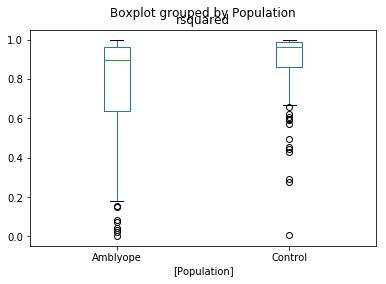

In [28]:
lin_results.boxplot(column='rsquared', by=['Population'], grid=False)

In [29]:
log_results = groups_with_baseline.apply(linear_fit_params, 'logRelMaskContrast', 'logThreshElev').reset_index()

In [30]:
log_results.rsquared.mean()

0.7417445472530505

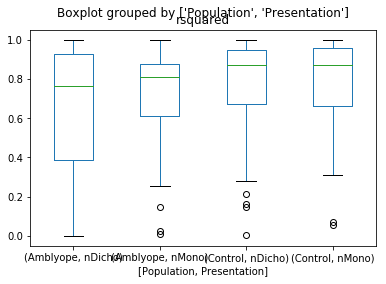

In [31]:
log_results.boxplot(column='rsquared', by=['Population','Presentation'], grid=False)

In [32]:
neg_slopes = lin_results[lin_results['slope']<0]
neg_slopes

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
12,SS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,6.210,1.023065,-0.006021,0.045044
14,SS,Cross,nDicho,Amblyope,jv,De,Amblyope-De,4.227,1.689517,-0.020405,0.181212
20,SS,Cross,nDicho,Amblyope,mv,De,Amblyope-De,5.981,1.260735,-0.020939,0.503098
22,SS,Cross,nDicho,Amblyope,rn,De,Amblyope-De,6.424,0.757355,-0.017022,0.021744
24,SS,Cross,nDicho,Amblyope,sd,De,Amblyope-De,6.262,0.706531,-0.017487,0.073372
53,SS,Cross,nDicho,Control,ms,Nde,Control-Nde,4.214,0.942228,-0.004734,0.622978
78,SS,Cross,nMono,Amblyope,jv,De,Amblyope-De,4.227,1.861288,-0.038142,0.319723
86,SS,Cross,nMono,Amblyope,rn,De,Amblyope-De,6.424,0.933673,-0.033097,0.494020
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,1.006648,-0.013177,0.152790


In [33]:
neg_slopes.Subject.unique()

array(['cl', 'gd', 'jv', 'mv', 'rn', 'sd', 'ms', 'bi', 'ct'], dtype=object)

In [34]:
def linear_fit_predictions(df, x, y):
    result = linear_fit(df, x, y)
    preds = pd.Series(result.predict(), index=df[x], name='ThreshPred')
    return preds

In [35]:
lin_preds = groups_with_baseline.apply(linear_fit_predictions, 'RelMaskContrast', 'ThreshElev').reset_index()

In [36]:
lin_preds.columns

Index(['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye',
       'Trace', 'BaselineThresh', 'RelMaskContrast', 'ThreshPred'],
      dtype='object')

In [37]:
lin_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.318,1.411635


In [38]:
plot_df = pd.merge(df_to_model, lin_preds, on=pp_gvars_base + ['RelMaskContrast'])

In [39]:
plot_df.columns

Index(['Subject', 'Task', 'Presentation', 'Orientation', 'Eye', 'Population',
       'MaskContrast', 'ThreshElev', 'ThreshElev_SE', 'RelMaskContrast',
       'Trace', 'BaselineThresh', 'BinCenterRelMaskContrast', 'BinNumber',
       'logThreshElev', 'logRelMaskContrast', 'ThreshPred'],
      dtype='object')

### Plot observed values and model fits

In [40]:
s.group_facet_plots(plot_df, s.subject_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Subject",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201901/SS_regressions_combinedplots_n35_TOP.pdf


In [41]:
s.group_facet_plots(plot_df, s.population_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TO.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Population",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201901/SS_regressions_combinedplots_n35_TO.pdf


### Pick an xvalue (RelMaskContrast) to evaluate models at

 * 2018-09-24: Abandoning Eunice's binning. Instead, try to figure out a good RelMaskContrast programatically.
   * Just looking at it via describe(), i'd say somewhere between 5 and 10 -- probably 6 (for SS) and 10 (for OS)
 * 2018-10-08: My previous approach was too subjective. Instead, evaluate model at various percentiles...
   * do this separately for Task, Orientation, Presentation (so pick 8 total numbers)
   * At this point it's easier to just use the statsmodels.ols functions maybe? The way it's currently done is a legacy that allows different models to be swapped in... which I hope to god is not going to be the direction we go in again.
   * nvm, used the lmfit solution since it returned a nicely formatted pfit df and is tested to work
   * Here I want to take the slope and y-int and calculate the model prediction at the specified percentiles above (0-1, increments of 0.2). So, first calculate the RelMC at each of those percentiles, then apply it like below.


In [42]:
percentile_bins = np.linspace(0, 1, num=11)

In [43]:
percentile_bins

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

#### Get the interpolated RelMaskContrasts for each regression line, i.e. the range of x-values

In [44]:
relmc_pcts_df = lin_preds.groupby(pp_gvars_base)['RelMaskContrast'].describe(percentiles=percentile_bins)

In [45]:
# fix stupid column naming from describe()
relmc_pcts_df.columns = [f"{int(float(col[:-1])):03d}" if col[-1]=="%" else col for col in relmc_pcts_df.columns]

In [46]:
relmc_pcts_df.columns

Index(['count', 'mean', 'std', 'min', '000', '010', '020', '030', '040', '050',
       '060', '070', '080', '090', '100', 'max'],
      dtype='object')

In [47]:
relmc_pcts_df = relmc_pcts_df.filter(regex='0|1')
relmc_pcts_df.head()

000  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh          
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.194   
                                                 Nde Amblyope-Nde 4.558           1.318   
                                         am      De  Amblyope-De  7.532           1.276   
                                                 Nde Amblyope-Nde 7.834           1.328   
                                         bi      De  Amblyope-De  7.827           0.986   

                                                                                     010  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.7205   
                                                 Nde Amblyope-Nde 4.558           1.6342   
                                         am      De  Amblyope-De  7.532           1.6848   
                                                 Nde Amblyope-Nde 7.834           1.7528   
                                         bi      De  Amblyope-De  7.827           1.3804   

                                                                                     020  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.2470   
                                                 Nde Amblyope-Nde 4.558           1.9504   
                                         am      De  Amblyope-De  7.532           2.0936   
                                                 Nde Amblyope-Nde 7.834           2.1776   
                                         bi      De  Amblyope-De  7.827           1.7748   

                                                                                     030  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.7735   
                                                 Nde Amblyope-Nde 4.558           2.2666   
                                         am      De  Amblyope-De  7.532           2.6554   
                                                 Nde Amblyope-Nde 7.834           2.7618   
                                         bi      De  Amblyope-De  7.827           2.1692   

                                                                                     040  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           4.5632   
                                                 Nde Amblyope-Nde 4.558           2.7408   
                                         am      De  Amblyope-De  7.532           3.3702   
                                                 Nde Amblyope-Nde 7.834           3.5054   
                                         bi      De  Amblyope-De  7.827           2.5636   

                                                                                     050  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           5.4845   
                                                 Nde Amblyope-Nde 4.558           3.2940   
                                         am      De  Amblyope-De  7.532           4.0850   
                                                 Nde Amblyope-Nde 7.834           4.2490   
                                         bi      De  Amblyope-De  7.827           2.9580   

                                                                                     060  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyop

In [48]:
relmc_pcts_df.columns

Index(['000', '010', '020', '030', '040', '050', '060', '070', '080', '090',
       '100'],
      dtype='object')

In [49]:
relmc_pcts_df_melted = relmc_pcts_df.reset_index().melt(id_vars=pp_gvars_base, var_name='percentile', value_name='RelMaskContrast_pct')

In [50]:
predict_pcts_df = pd.merge(lin_results, relmc_pcts_df_melted, on=pp_gvars_base)

In [51]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,000,2.1940
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,010,2.7205
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,020,3.2470
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,030,3.7735
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,040,4.5632


In [52]:
predict_pcts_df['percentile'] = predict_pcts_df['percentile'].astype(int)
predict_pcts_df['RelMaskContrast_pct'] = predict_pcts_df['RelMaskContrast_pct'].astype(float)
predict_pcts_df['relmc_bin'] = (np.around(predict_pcts_df['RelMaskContrast_pct'])).astype(int)
predict_pcts_df['ThreshElev_pct'] = (predict_pcts_df['y_int'] + (predict_pcts_df['RelMaskContrast_pct']*predict_pcts_df['slope'])).astype('float')

In [53]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,0,2.1940,2,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,10,2.7205,3,0.751589
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,20,3.2470,3,0.760684
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,30,3.7735,4,0.769779
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,40,4.5632,5,0.783421


### Plot the model fits only

In [54]:
s.group_facet_plots(predict_pcts_df, s.subject_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="Subject",fmt_obs='.') 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201901/SS_regressions_pcts_n35_TOP.pdf


In [55]:
s.group_facet_plots(predict_pcts_df, s.population_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TO.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="Population",fmt_obs='.') 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201901/SS_regressions_pcts_n35_TO.pdf


In [56]:
s.group_facet_plots(predict_pcts_df, s.population_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TO_bin.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="relmc_bin",fmt_obs='.') 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201901/SS_regressions_pcts_n35_TO_bin.pdf


### Conclusions from these regression plots (_TO):
 * SS: looks fine, esp with new binning (IMO).
 * OS: one or two subjects really messes up the axes. One bc of a huge error bar on their observed ThreshElev, one but v low predicted ThreshElev by model; exclude? Both are controls so part of the larger group.
   * This only happens in Iso-orientation, which is different from Cross in substantial ways. What does that indicate?

In [57]:
gvars_test = ['Task','Orientation','Presentation','Population']
# equal_var=False makes it Welch's t-test, which does not assume the groups have equal variance
selected_bin_df = utils.find_pct_to_predict(predict_pcts_df, gvars_test,
                    'relmc_bin', 'ThreshElev_pct', test_func=st.ttest_ind, equal_var=False)

There are 21 bins in this condition.
26 DE obs, 21 NDE obs
p-value: 0.0000388255
26 DE obs, 21 NDE obs
p-value: 0.0000388255
29 DE obs, 28 NDE obs
p-value: 0.0000029296
21 DE obs, 17 NDE obs
p-value: 0.0007149654
13 DE obs, 14 NDE obs
p-value: 0.0050349718
11 DE obs, 12 NDE obs
p-value: 0.0269326683
6 DE obs, 13 NDE obs
p-value: 0.0017816885
4 DE obs, 8 NDE obs
p-value: 0.0174435691
7 DE obs, 4 NDE obs
p-value: 0.2422992946
6 DE obs, 5 NDE obs
p-value: 0.0314393948
4 DE obs, 4 NDE obs
p-value: 0.6915144926
2 DE obs, 4 NDE obs
p-value: 0.3699569572
4 DE obs, 3 NDE obs
p-value: 0.3010754783
3 DE obs, 1 NDE obs
p-value: nan
1 DE obs, 1 NDE obs
p-value: nan
2 DE obs, 2 NDE obs
p-value: 0.4677900028
2 DE obs, 1 NDE obs
p-value: nan
1 DE obs, 2 NDE obs
p-value: nan
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 21 bins in this condition.
26 DE obs, 21 NDE obs
p-value: 0.0000388

//anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


relmc_bin 14 has lowest p-value.

There are 21 bins in this condition.
Not in suppression, mean of both eyes is < 1.
Not in suppression, mean of both eyes is < 1.
Not in suppression, mean of both eyes is < 1.
15 DE obs, 19 NDE obs
p-value: 0.0032983143
15 DE obs, 14 NDE obs
p-value: 0.0059226306
10 DE obs, 11 NDE obs
p-value: 0.0665061590
12 DE obs, 7 NDE obs
p-value: 0.2365020175
7 DE obs, 5 NDE obs
p-value: 0.2193408347
5 DE obs, 6 NDE obs
p-value: 0.2420028830
4 DE obs, 6 NDE obs
p-value: 0.9286218757
4 DE obs, 6 NDE obs
p-value: 0.8372670135
4 DE obs, 1 NDE obs
p-value: nan
5 DE obs, 5 NDE obs
p-value: 0.8380801955
3 DE obs, 2 NDE obs
p-value: 0.4145661347
3 DE obs, 2 NDE obs
p-value: 0.7469033408
2 DE obs, 3 NDE obs
p-value: 0.3417883044
2 DE obs, 1 NDE obs
p-value: nan
4 DE obs, 2 NDE obs
p-value: 0.7635952329
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 3 has lowest p-value.

There are 24 bins i

763               2.5636          3        1.085150                3  
     Task Orientation Presentation Population Subject Eye       Trace  \
999    SS       Cross        nMono    Control      ai  De  Control-De   
1108   SS       Cross        nMono    Control      ei  De  Control-De   
1131   SS       Cross        nMono    Control      es  De  Control-De   
1151   SS       Cross        nMono    Control      gm  De  Control-De   
1184   SS       Cross        nMono    Control      jd  De  Control-De   

      BaselineThresh     y_int     slope  rsquared  percentile  \
999            6.943  0.329513  0.069870  0.991830          90   
1108           6.458  0.542437  0.031576  0.607023          80   
1131           5.478  0.747836  0.049523  0.766640          90   
1151           6.630  0.469215  0.042828  0.929743          70   
1184           5.576  0.564955  0.054785  0.782105          70   

      RelMaskContrast_pct  relmc_bin  ThreshElev_pct  BinNumberToPred  
999                8.

In [58]:
g_TOP = selected_bin_df.groupby(['Task', 'Orientation', 'Presentation'])
def set_relmctopred_to_amb_val(g):
    ambs = g[g['Population']=='Amblyope']
    assert(np.all(ambs['RelMCToPred']==ambs['RelMCToPred'].iat[0]))
    assert(np.all(ambs['BinNumberToPred']==ambs['BinNumberToPred'].iat[0]))
    g['RelMCToPred'] = ambs['RelMCToPred'].iat[0]
    g['BinNumberToPred'] = ambs['BinNumberToPred'].iat[0]
    return g
selected_bin_df = g_TOP.apply(set_relmctopred_to_amb_val).reset_index()

In [59]:
selected_bin_df.groupby(gvars_test)['RelMCToPred','ThreshElev_pct'].describe()

RelMCToPred                           \
                                               count mean  std  min  25%  50%   
Task Orientation Presentation Population                                        
SS   Cross       nDicho       Amblyope         286.0  2.0  0.0  2.0  2.0  2.0   
                              Control          418.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         286.0  3.0  0.0  3.0  3.0  3.0   
                              Control          418.0  3.0  0.0  3.0  3.0  3.0   
     Iso         nDicho       Amblyope         286.0  2.0  0.0  2.0  2.0  2.0   
                              Control          418.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         286.0  2.0  0.0  2.0  2.0  2.0   
                              Control          418.0  2.0  0.0  2.0  2.0  2.0   

                                                   ThreshElev_pct            \
                                          75%  max          count      mean   
Task Orientation Presentation Population                                      
SS   Cross       nDicho       Amblyope    2.0  2.0          286.0  1.262209   
                              Control     2.0  2.0          418.0  1.280118   
                 nMono        Amblyope    3.0  3.0          286.0  1.028793   
                              Control     3.0  3.0          418.0  0.968797   
     Iso         nDicho       Amblyope    2.0  2.0          286.0  1.647164   
                              Control     2.0  2.0          418.0  1.946808   
                 nMono        Amblyope    2.0  2.0          286.0  1.477358   
                              Control     2.0  2.0          418.0  1.579746   

                                                                        \
                                               std       min       25%   
Task Orientation Presentation Population                                 
SS   Cross       nDicho       Amblyope    0.604570  0.484123  0.906052   
                              Control     0.447799  0.661363  0.934000   
                 nMono        Amblyope    0.292618  0.344715  0.870899   
                              Control     0.257849  0.430126  0.800983   
     Iso         nDicho       Amblyope    1.083098  0.260012  0.999914   
                              Control     0.895063  0.474386  1.294571   
                 nMono        Amblyope    0.832965  0.366306  0.871969   
                              Control     0.938111  0.432981  0.930592   

                                                                        
                                               50%       75%       max  
Task Orientation Presentation Population                                
SS   Cross       nDicho       Amblyope    1.129119  1.457494  4.674826  
                              Control     1.184204  1.501520  3.959224  
                 nMono        Amblyope    0.999258  1.202717  2.219274  
                              Control     0.931696  1.110994  2.078230  
     Iso         nDicho       Amblyope    1.271437  2.025497  6.242498  
                              Control     1.786777  2.392381  5.881773  
                 nMono        Amblyope    1.203732  1.918966  4.903989  
                              Control     1.300831  1.972276  6.689321

In [60]:
selected_bin_df['ThreshPredCritical'] = selected_bin_df['y_int'] + selected_bin_df['slope'] * selected_bin_df['RelMCToPred']
selected_bin_df['ThreshPredCriticalUnnorm'] = selected_bin_df['ThreshPredCritical'] * selected_bin_df['BaselineThresh']

In [61]:
selected_bin_df

,index,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct,BinNumberToPred,RelMCToPred,ThreshPredCritical,ThreshPredCriticalUnnorm
0,0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,0,2.1940,2,0.742493,2,2,0.739142,5.610087
1,1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,10,2.7205,3,0.751589,2,2,0.739142,5.610087
2,2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,20,3.2470,3,0.760684,2,2,0.739142,5.610087
3,3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,30,3.7735,4,0.769779,2,2,0.739142,5.610087
4,4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,40,4.5632,5,0.783421,2,2,0.739142,5.610087
5,5,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,50,5.4845,5,0.799337,2,2,0.739142,5.610087
6,6,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,60,6.4058,6,0.815252,2,2,0.739142,5.610087
7,7,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,70,7.5466,8,0.834960,2,2,0.739142,5.610087
8,8,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,80,9.1264,9,0.862251,2,2,0.739142,5.610087
9,9,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,90,10.7062,11,0.889542,2,2,0.739142,5.610087


### Melt the result of the modeling into long format for plotting

In [62]:
pfit_all_ppsub = pd.melt(selected_bin_df, id_vars=pp_gvars,
                    value_vars=['BaselineThresh', 'y_int', 'slope', 'ThreshPredCritical', 'ThreshPredCriticalUnnorm'],
                    var_name='measure')
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59


## Subset to include only (GABA and psychophyics) subjects

In [63]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [64]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.


In [65]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
print(f"Of the {len(gdf)} subjects with GABA and {task} data, {len(gdf[gdf.Population=='Amblyope'])} are Amblyopes.")
n_this_task = len(gdf)

Of the 23 subjects with GABA and SS data, 0 are Amblyopes.


## Combine Psychophysics and GABA below

In [66]:
#Grab the GABA measure for each subject and append it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)
print(len(comb))

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]
print(len(comb_gabappsub), f"{len(np.unique(comb_gabappsub.Subject))} subjects")

1280
920 23 subjects


In [67]:
comb_gabappsub.head(n=10)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
22,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,7.532,0.193
33,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834,0.193
44,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827,0.207
55,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,10.141,0.207
110,SS,Cross,nDicho,Amblyope,em,De,Amblyope-De,BaselineThresh,5.949,0.182
121,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,BaselineThresh,6.014,0.182
132,SS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,BaselineThresh,6.210,0.203
143,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,BaselineThresh,6.536,0.203
154,SS,Cross,nDicho,Amblyope,jv,De,Amblyope-De,BaselineThresh,4.227,0.215
165,SS,Cross,nDicho,Amblyope,jv,Nde,Amblyope-Nde,BaselineThresh,4.764,0.215


In [68]:
spearman_df = comb_gabappsub[(comb_gabappsub.measure == 'BaselineThresh') | (comb_gabappsub.measure == 'ThreshPredCritical')]

In [69]:
plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','Eye','Trace','measure'])
for gv, gr in plot_groups:
    if gv[-1] == "ThreshPredCritical" and 'nDicho' in gv:
        print(gv)
        print(stats.spearmanr(gr.GABA, gr.value))

('SS', 'Cross', 'nDicho', 'Amblyope', 'De', 'Amblyope-De', 'ThreshPredCritical')
SpearmanrResult(correlation=0.8833333333333333, pvalue=0.0015905004234978686)
('SS', 'Cross', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.41666666666666663, pvalue=0.26458604674749614)
('SS', 'Cross', 'nDicho', 'Control', 'De', 'Control-De', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.32343253895020996, pvalue=0.25931922639863075)
('SS', 'Cross', 'nDicho', 'Control', 'Nde', 'Control-Nde', 'ThreshPredCritical')
SpearmanrResult(correlation=0.17821792962562585, pvalue=0.54214547955936121)
('SS', 'Iso', 'nDicho', 'Amblyope', 'De', 'Amblyope-De', 'ThreshPredCritical')
SpearmanrResult(correlation=0.71666666666666667, pvalue=0.029818035695845287)
('SS', 'Iso', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.51666666666666672, pvalue=0.15439012098622509)
('SS', 'Iso', 'nDicho', 'Control', 'De', 'Control

In [70]:
#graphs!
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#ffc68c","#e1812c"]
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_linear.pdf") as pdf:
    plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure'])
    for gv, gr in plot_groups:
        if gv[2] == 'nDicho':
            print(gv, np.all(np.isnan(gr['value'])))
            pal = [colors_amb if gv[-2] in ['Amblyope'] else colors_con]
            g2 = s.gaba_vs_psychophys_plot_2line_nofacet(gv, gr, palette=pal[0], aspect=1.2)
            pdf.savefig(g2.fig)

plt.close('all')

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh') False
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical') False
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh') False
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical') False
('SS', 'Iso', 'nDicho', 'Amblyope', 'BaselineThresh') False
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical') False
('SS', 'Iso', 'nDicho', 'Control', 'BaselineThresh') False
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical') False


### Conclusions from the graphs we just generated
#### The conclusions below are a couple iterations old but should still be true
#### SS, but using old bins initially; updated with new bins info:
 * BaselineThresh
    * There is a negative relationship between GABA and BaselineThresh for both eyes, both populations, both surround conditions. This is an interesting finding in itself...
      * (nDicho and nMono are identical since this is baseline thresh, ie just one eye)
      * new bins: this remains true.
 * DepthOfSuppression
    * In SS/Cross/Dicho, more GABA = less suppression of NDE, but = more suppression of DE. This is especially true of Amblyopes, while in Controls the effect is weak/insignificant.
      * new bins: this remains true, and the positive slope of GABA vs suppression for the DE is higher in nMono than nDicho -- what does this mean?
    * In SS/Iso/Dicho, more GABA = less suppression of NDE, = more suppression of DE. Effect is very strong for Amblyopes and absent for other conditions(AMB/Mono and all Controls)
      * new bins: still true
 * Critical Bin Center (RelMCToPred)
    * In SS/Cross/Dicho the NDE has a higher (numerically, in multiples of baseline) RelMCToPred for both AMB and CON
    * But in SS/Cross/Mono it's the reverse, DE has higher RelMCToPred for both populations
    * new bins: this measure is rendered obsolete since I handpicked an x-val
 * ThreshPredCritical
    * For both Cross and Iso, Dicho/AMB shows biggest difference b/t NDE and DE in predicted threshold elevation. Other conditions show little to no difference.
    * new bins: now seeing this effect in AMB/nMono, similar to DepthofSuppression
 * ThreshPredCriticalUnnorm
    * When we normalize by each eye's baseline, this effect is still present.
    * new bins: still true, and unlike baseline-normalized ThreshPredCritical, effect not present in nMono (ie same pattern as with the old bins)
 * Linear model slope
    * AMB/Dicho shows biggest difference between trends in each eye for both presentation conditions. more GABA ~ lower slope of the line for NDE, while DE is basically flat.
    * new bins: nMono shows effect too, AMB look v different than controls, esp in Dicho.
 * Linear model y-int
    * AMB/Dicho has opposite GABA vs y-int slopes for both Iso and Cross, but the distributions overlap for all conditions and populations, so this is a weak finding.
    * new bins: same
    
#### OS, new bins
 * BaselineThresh
   * no strong trends vs GABA for either Iso or Cross.
 * DepthOfSuppression
   * Cross: positive slope for NDE in all conditions, much stronger in Dicho. DE flat in all, p much.
   * Iso: negative slope for NDE in AMB/Dicho. Positive/flat slopes in other conditions, and for De slopes 
 * Critical Bin Center (RelMCToPred): handpicked
 * ThreshPredCritical
   * Cross: NDE positive, DE flat-ish, least CI overlap in AMB/Dicho
   * Iso: everything overlaps a lot. least so in AMB/Dicho (NDE vs DE)
 * ThreshPredCriticalUnnorm
   * Cross: Same as normalized, but bigger diff/less overlap in AMB/Dicho than normalized.
   * Iso: everything overlaps a lot. least so in AMB/Dicho
 * Linear model slope
   * Cross: basically all flat, except nMono/AMB/NDE? Weak/nonexistent/CI overlappy tho.
   * Iso: Trending opposite DE/NDE but all overlap a lot
 * Linear model y-int
   * Cross: NDE slopes positive (for both AMB and CON, but higher magnitude for AMB), least overlap in AMB/Dicho
   * NDE vs DE trend similar in Dicho but opposite in Mono (for both Con and AMB), but lots of overlap


### Combine measures across the two eyes

 * Does it make sense to combine all measures across both eyes (i.e. by subtracting?) For example, ThreshElev is in units of baseline, and the baseline varies by eye. So perhaps only a few measures should be combined -- say, slope/yint, ThreshPredCriticalUnnorm. 

In [71]:
measures = comb_gabappsub[comb_gabappsub["measure"].isin(["BaselineThresh","ThreshPredCritical"])]

In [72]:
np.unique(measures.measure)

array(['BaselineThresh', 'ThreshPredCritical'], dtype=object)

In [73]:
paired_obs = measures.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2: # this will exclude paired observations where there was no data for one eye
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])

In [74]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

In [75]:
obs_diff[obs_diff.Subject=='em']

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De
4,SS,Cross,Amblyope,nDicho,em,BaselineThresh,0.065000
5,SS,Cross,Amblyope,nDicho,em,ThreshPredCritical,1.726276
22,SS,Cross,Amblyope,nMono,em,BaselineThresh,0.065000
23,SS,Cross,Amblyope,nMono,em,ThreshPredCritical,0.338556
96,SS,Iso,Amblyope,nDicho,em,BaselineThresh,0.065000
97,SS,Iso,Amblyope,nDicho,em,ThreshPredCritical,1.362006
114,SS,Iso,Amblyope,nMono,em,BaselineThresh,0.065000
115,SS,Iso,Amblyope,nMono,em,ThreshPredCritical,0.369893


In [76]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [77]:
comb_botheyes.head()

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA
0,SS,Cross,Amblyope,nDicho,am,BaselineThresh,0.302000,0.193
1,SS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.703950,0.193
2,SS,Cross,Amblyope,nDicho,bi,BaselineThresh,2.314000,0.207
3,SS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,0.311639,0.207
4,SS,Cross,Amblyope,nDicho,em,BaselineThresh,0.065000,0.182


In [78]:
print(len(np.unique(comb_botheyes.Subject)))

23


In [79]:
test_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','Population','measure'])
for gv, gr in test_groups:
    #print(gr.head())
    if gv[-1]=="ThreshPredCritical":
        print(gv)
        print(stats.spearmanr(gr.GABA, gr['Nde-De']))

('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.81666666666666665, pvalue=0.0072247852463587859)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=0.36523674466486294, pvalue=0.19910645761014112)
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.83333333333333326, pvalue=0.005265691029161748)
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=0.063806419248680871, pvalue=0.82844034016184465)
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.56666666666666665, pvalue=0.11163298761149111)
('SS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=0.16501660150520917, pvalue=0.57291851227121526)
('SS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=-0.51666666666666672, pvalue=0.15439012098622509)
('SS', 'Iso', 'nMono', 'Control', 'ThreshPred

In [80]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'BaselineThresh')
('SS', 'Cross', 'ThreshPredCritical')
('SS', 'Iso', 'BaselineThresh')
('SS', 'Iso', 'ThreshPredCritical')


In [81]:
# more graphs for presentation!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}_poster.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','measure'])
    for gv, gr in plot_groups:
        if gv[-2] in ["nDicho"]: # use this line to exclude measures we don't want
            print(gv)
            g2 = s.gaba_vs_psychophys_plot_2line_2eye_nofacet(gv, gr, hue="Population", size=5, aspect=1.2, legend=False)
            #print(g2.axes)
            pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'nDicho', 'BaselineThresh')
('SS', 'Cross', 'nDicho', 'ThreshPredCritical')
('SS', 'Iso', 'nDicho', 'BaselineThresh')
('SS', 'Iso', 'nDicho', 'ThreshPredCritical')


### Conclusions from Interocular suppression graphs
#### SS, new bins
 * Interocular difference measures all seem to get back to “the two eyes of amblyopes are more different than the two eyes of controls, and the magnitude of this difference is inversely related to GABA).
   * This is interesting and we want to present it, right?
#### OS, new bins:
 * Some strong effects in y-int Iso in both Dicho and esp. Mono. Cross is a wash
 * Other measures look fairly similar?

### FMRI stuff and graphs!

In [82]:
fmri_fn = 'fmri_data.txt'
fmri_df = utils.load_fmri(fmri_fn)
fmri_df.head()

,subjName,BinSumDiffV1,BinSumDiffV2d,BinSumDiffV2v,BinSumDiffV3d,BinSumDiffV3v
0,ac,0.598,0.654,0.646,0.361,0.458
1,ai,0.897,0.499,1.022,0.214,0.558
2,am,0.078,0.396,0.218,0.192,-1.156
3,as,0.011,0.148,-0.016,-0.000,-0.078
4,bi,0.129,0.406,0.290,0.112,0.104


In [83]:
comb_botheyes = comb_botheyes.join(fmri_df.set_index(['subjName']), on=['Subject'])
comb_botheyes.head()

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA,BinSumDiffV1,BinSumDiffV2d,BinSumDiffV2v,BinSumDiffV3d,BinSumDiffV3v
0,SS,Cross,Amblyope,nDicho,am,BaselineThresh,0.302000,0.193,0.078,0.396,0.218,0.192,-1.156
1,SS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.703950,0.193,0.078,0.396,0.218,0.192,-1.156
2,SS,Cross,Amblyope,nDicho,bi,BaselineThresh,2.314000,0.207,0.129,0.406,0.290,0.112,0.104
3,SS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,0.311639,0.207,0.129,0.406,0.290,0.112,0.104
4,SS,Cross,Amblyope,nDicho,em,BaselineThresh,0.065000,0.182,0.107,0.170,0.052,-0.112,-0.028


In [84]:
slim_df = comb_botheyes[comb_botheyes['measure']=='ThreshPredCritical']
final_df = pd.melt(slim_df,
                   id_vars=['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure', 'Nde-De', 'GABA'],
                   var_name='BinSumArea')
final_df.head()

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA,BinSumArea,value
0,SS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.703950,0.193,BinSumDiffV1,0.078
1,SS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,0.311639,0.207,BinSumDiffV1,0.129
2,SS,Cross,Amblyope,nDicho,em,ThreshPredCritical,1.726276,0.182,BinSumDiffV1,0.107
3,SS,Cross,Amblyope,nDicho,gd,ThreshPredCritical,-0.092658,0.203,BinSumDiffV1,-0.277
4,SS,Cross,Amblyope,nDicho,jv,ThreshPredCritical,-1.351153,0.215,BinSumDiffV1,0.342


In [85]:
final_df[final_df['Subject']=='am']
# based on this, we know that for GABA vs FMRI, we can reduce to just Iso/Dicho (all other orientation/pres combos the same)

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA,BinSumArea,value
0,SS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.703950,0.193,BinSumDiffV1,0.078
9,SS,Cross,Amblyope,nMono,am,ThreshPredCritical,0.511640,0.193,BinSumDiffV1,0.078
46,SS,Iso,Amblyope,nDicho,am,ThreshPredCritical,1.223189,0.193,BinSumDiffV1,0.078
55,SS,Iso,Amblyope,nMono,am,ThreshPredCritical,0.354380,0.193,BinSumDiffV1,0.078
92,SS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.703950,0.193,BinSumDiffV2d,0.396
101,SS,Cross,Amblyope,nMono,am,ThreshPredCritical,0.511640,0.193,BinSumDiffV2d,0.396
138,SS,Iso,Amblyope,nDicho,am,ThreshPredCritical,1.223189,0.193,BinSumDiffV2d,0.396
147,SS,Iso,Amblyope,nMono,am,ThreshPredCritical,0.354380,0.193,BinSumDiffV2d,0.396
184,SS,Cross,Amblyope,nDicho,am,ThreshPredCritical,0.703950,0.193,BinSumDiffV2v,0.218
193,SS,Cross,Amblyope,nMono,am,ThreshPredCritical,0.511640,0.193,BinSumDiffV2v,0.218


In [86]:
np.unique(final_df.Subject)

array(['ai', 'am', 'bi', 'cr', 'ct', 'dl', 'ei', 'em', 'es', 'gd', 'gm',
       'jd', 'jv', 'kw', 'li', 'ls', 'mg', 'mk', 'ms', 'nl', 'rn', 'sd',
       'yl'], dtype=object)

In [87]:
gaba_fmri_df = final_df[(final_df['Presentation']=='nDicho') & (final_df['Orientation']=='Iso')]
r_groups_pop = gaba_fmri_df.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'BinSumArea'])
for rgv, rgr in r_groups_pop:
    print(rgv, len(rgr.value))
    print(rgr[['GABA','value']].describe())
    print('Mean BinSumDiff: ', np.mean(rgr.value))
    r_gaba_fmri = stats.spearmanr(rgr['GABA'], rgr['value'])
    #r_gaba_thresh = (rgr.corr()['GABA']['Nde-De'])
    print('GABA and fMRI:', r_gaba_fmri)
    if r_gaba_fmri.pvalue < .05:
        print("^^^^*****^^^^^^")
    #print('GABA and Nde-De:', r_gaba_thresh, r_gaba_thresh**2)

('SS', 'Iso', 'nDicho', 'Amblyope', 'BinSumDiffV1') 9
           GABA     value
count  9.000000  9.000000
mean   0.203222  0.226333
std    0.013673  0.351434
min    0.182000 -0.277000
25%    0.193000  0.078000
50%    0.203000  0.129000
75%    0.210000  0.342000
max    0.227000  0.900000
Mean BinSumDiff:  0.22633333333333333
GABA and fMRI: SpearmanrResult(correlation=-0.14999999999999999, pvalue=0.70009423096914192)
('SS', 'Iso', 'nDicho', 'Amblyope', 'BinSumDiffV2d') 9
           GABA     value
count  9.000000  9.000000
mean   0.203222  0.371111
std    0.013673  0.213109
min    0.182000  0.040000
25%    0.193000  0.170000
50%    0.203000  0.396000
75%    0.210000  0.521000
max    0.227000  0.654000
Mean BinSumDiff:  0.3711111111111111
GABA and fMRI: SpearmanrResult(correlation=0.0, pvalue=1.0)
('SS', 'Iso', 'nDicho', 'Amblyope', 'BinSumDiffV2v') 9
           GABA     value
count  9.000000  9.000000
mean   0.203222  0.243556
std    0.013673  0.233555
min    0.182000 -0.026000
25%    0.1

In [88]:
with s.PdfPages(f"{plot_dir}/fmri_binsum_diffs.pdf") as pdf:
    ax = sns.barplot(x='BinSumArea', y='value', hue='Population', ci=68, capsize=.1, data=final_df)
    ax.legend().set_visible(False)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

In [89]:
#graphs!

with s.PdfPages(f"{plot_dir}/gaba_vs_fmri_joint.pdf") as pdf:
    plot_groups = gaba_fmri_df.groupby(['Task','Orientation','Presentation','BinSumArea'])
    for gv, gr in plot_groups:
        print(gv)
        xvar = "GABA"
        yvar = "value"
        x_lbl = "GABA (relative to creatine)"
        y_lbl = {'(Binocular - Dichoptic) BOLD amplitude (% signal)'}
        g = sns.lmplot(data=gr,hue='Population',# facet rows and columns
                  x=xvar, y=yvar,sharey=False, legend=False)
        #g.fig.suptitle(gv, fontsize=16, y=0.99)
        #g.fig.subplots_adjust(top=.9, right=.8)
        g.set_axis_labels('', '')
        g.set_xticklabels('','')
        pdf.savefig(g.fig)
        plt.close(g.fig)
    plt.close('all')

('SS', 'Iso', 'nDicho', 'BinSumDiffV1')
('SS', 'Iso', 'nDicho', 'BinSumDiffV2d')
('SS', 'Iso', 'nDicho', 'BinSumDiffV2v')
('SS', 'Iso', 'nDicho', 'BinSumDiffV3d')
('SS', 'Iso', 'nDicho', 'BinSumDiffV3v')


### Orientation-selective suppression can go here

 * We should start off by doing each eye separately, right? So, starting from comb_gabappsub df.
 * Or if we started from the combined-eye data generated above, use measures df.

In [90]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace", "measure", "GABA"]

In [91]:
def calculate_orientation_selective_suppression(df, **kwargs):
    #print(df[['Orientation', 'value']])
    iso_cross_oss_ratio = df[df.Orientation=='Iso']['value'].iloc[0]/df[df.Orientation=='Cross']['value'].iloc[0]
    print(f"Iso/Cross ratio: {iso_cross_oss_ratio}")
    return pd.Series(iso_cross_oss_ratio, ['value'])
    #print(df[df['Orientation'=='Cross']]) #/df[df['Orientation'=='Cross']]['value']

In [92]:
oss_df = comb_gabappsub.groupby(oss_gvars).apply(calculate_orientation_selective_suppression).reset_index()

Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.8901754309215941
Iso/Cross ratio: 0.8901754309215941
Iso/Cross ratio: 2.5207529900873307
Iso/Cross ratio: 0.8326047317751777
Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.389746063521855
Iso/Cross ratio: 1.389746063521855
Iso/Cross ratio: 4.54243491890515
Iso/Cross ratio: 0.9078617162505119
Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.101863586205471
Iso/Cross ratio: 1.101863586205471
Iso/Cross ratio: -0.8811696831153363
Iso/Cross ratio: 1.1708444828417524
Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.0805794306213778
Iso/Cross ratio: 1.0805794306213778
Iso/Cross ratio: 2.5524410856603086
Iso/Cross ratio: 0.07100018639995295
Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.1269549459477206
Iso/Cross ratio: 1.1269549459477206
Iso/Cross ratio: 2.7264970446296166
Iso/Cross ratio: 1.0715157463819414
Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.8804992773062316
Iso/Cross ratio: 0.8804992773062315
Iso/Cross ratio: 0.49453092649085284
Iso/Cross ratio: 2.532084307

Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.691158672533219
Iso/Cross ratio: 0.691158672533219
Iso/Cross ratio: 5.706071914432673
Iso/Cross ratio: 0.4045677782880662
Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.9286312782890174
Iso/Cross ratio: 0.9286312782890174
Iso/Cross ratio: 3.575075043503141
Iso/Cross ratio: 0.23045133839872853
Iso/Cross ratio: 1.0
Iso/Cross ratio: 1.2540233588118126
Iso/Cross ratio: 1.2540233588118126
Iso/Cross ratio: 2.1585863837335157
Iso/Cross ratio: 1.1363193492912327
Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.9452621247080639
Iso/Cross ratio: 0.9452621247080638
Iso/Cross ratio: 2.588394607342201
Iso/Cross ratio: 0.6321444004513916
Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.5734741683421525
Iso/Cross ratio: 0.5734741683421526
Iso/Cross ratio: 28.275208407473137
Iso/Cross ratio: -0.14247489230558047
Iso/Cross ratio: 1.0
Iso/Cross ratio: 0.6666764335695464
Iso/Cross ratio: 0.6666764335695464
Iso/Cross ratio: 4.684207350558242
Iso/Cross ratio: 0.027843661769699594
Iso/Cross r

In [93]:
oss_df.head()

,Task,Presentation,Population,Subject,Eye,Trace,measure,GABA,value
0,SS,nDicho,Amblyope,am,De,Amblyope-De,BaselineThresh,0.193,1.000000
1,SS,nDicho,Amblyope,am,De,Amblyope-De,ThreshPredCritical,0.193,0.890175
2,SS,nDicho,Amblyope,am,De,Amblyope-De,ThreshPredCriticalUnnorm,0.193,0.890175
3,SS,nDicho,Amblyope,am,De,Amblyope-De,slope,0.193,2.520753
4,SS,nDicho,Amblyope,am,De,Amblyope-De,y_int,0.193,0.832605


In [94]:
oss_df.columns

Index(['Task', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace',
       'measure', 'GABA', 'value'],
      dtype='object')

In [95]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_oss_n{n_this_task}.pdf") as pdf:
    plot_groups = oss_df.groupby(['Task','measure'])
    for gv, gr in plot_groups:
        if gv[-1] not in ["BaselineThresh", "RelMCToPred"]:
            print(gv, np.all(np.isnan(gr['value'])))
            g2 = s.gaba_vs_oss_plot_2line(gv, gr)
            pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'ThreshPredCritical') False
('SS', 'ThreshPredCriticalUnnorm') False
('SS', 'slope') False
('SS', 'y_int') False


### Conclusions from these graphs:
#### SS new and old bins, they're all the same
 * The two eyes seem to not be that different in their Iso/Cross ratios of the various measures.

#### OS new bins
 * NDE vs DE Iso/Cross ratios often trend different relative to GABA, but CIs overlap.